[INFO] [B200] Detected Device: B210
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 32.000000 MHz... 
[INFO] [B200] Actually got clock rate 32.000000 MHz.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
/tmp/ipykernel_29516/1907226827.py:202: DeprecationWarning: setName() is deprecated, set the name attribute instead
  rx_thread.setName("rx_worker")
/tmp/ipykernel_29516/1907226827.py:206: DeprecationWarning: setName() is deprecated, set the name attribute instead


Finished RX
Finished cycle
Finished RX
Finished cycle
Finished RX
Finished cycle
Finished RX
Finished cycle
Finished RX
Finished cycle


LLLLLLLLLLLLLLLLLLLL

Finished RX
Finished cycle
Finished RX
Finished cycle
Finished RX
Finished cycle
Finished RX
Finished cycle
Finished RX
Finished cycle


LLLLLLLLLLLL

Finished RX
Finished cycle
current_freq
States.RX_AND_SAVE_DATA
done


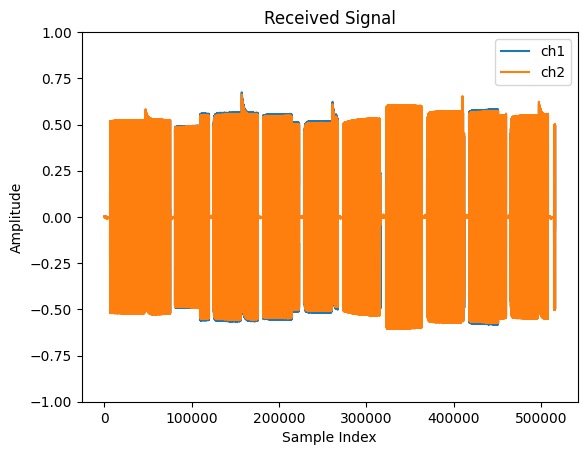

SystemExit: True

In [5]:
from datetime import datetime, timedelta
from enum import Enum
import sys
import time
import threading
import numpy as np
import uhd
from uhd import libpyuhd as lib
import matplotlib.pyplot as plt



INIT_DELAY = 0.01
CHIRP_LEN = 80000
CHIRP_BANDWIDTH = 0.5e6


class States(Enum):
    """Enumerations to represent different states."""
    TUNE_CENTER_FREQ = 1
    RX_AND_SAVE_DATA = 2
    DONE = 3

class StateManager:
    """Class to manage state transitions."""
    def __init__(self):
        self.state = States.TUNE_CENTER_FREQ

    def set_state(self, state):
        self.state = state

    def get_state(self):
        return self.state

state_manager = StateManager()     
        
def tune_center_freq(usrp, current_freq, channel_list, tx_gain, tx_gain2, rx_gaina, rx_gainb):
    """Tune the center frequency and set the appropriate gain."""
    # Tune the center frequencies
    usrp.set_rx_freq(lib.types.tune_request(current_freq), 0)
    usrp.set_rx_freq(lib.types.tune_request(current_freq), 1)
    usrp.set_tx_freq(lib.types.tune_request(current_freq), 0)
    usrp.set_tx_freq(lib.types.tune_request(current_freq), 1)
    # Different paradigms above and below 2.6e9 (this is from the literature)
    if current_freq < 2.6e9:
        usrp.set_tx_gain(tx_gain, channel_list[0])
        usrp.set_rx_gain(rx_gaina, channel_list[0])
        usrp.set_rx_gain(rx_gainb, channel_list[1])
    elif current_freq >= 2.6e9:
        usrp.set_tx_gain(tx_gain2, channel_list[0])
        usrp.set_rx_gain(rx_gaina, channel_list[0])
        usrp.set_rx_gain(rx_gainb, channel_list[1])

    # Wait for the local oscillators to lock
    while not(
        usrp.get_rx_sensor("lo_locked", 0).to_bool()
        and usrp.get_tx_sensor("lo_locked", 0).to_bool()
        ):
        pass
    state_manager.set_state(States.RX_AND_SAVE_DATA)
    return

def rx_worker(usrp, current_freq, rx_streamer, random, num_samps, rx_buffer_list, rx_buffer_list_ch2):

    num_rx_samps =0
    received_samples = []
    received_samples_ch2 = []
    # Make a receive buffer
    num_channels = rx_streamer.get_num_channels()
    max_samps_per_packet = rx_streamer.get_max_num_samps()
    recv_buffer = np.empty((num_channels, max_samps_per_packet), dtype=np.complex64)
    metadata = uhd.types.RXMetadata()

    # Craft and send the Stream Command
    stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.start_cont)
    stream_cmd.stream_now = (num_channels == 1)
    stream_cmd.time_spec = uhd.types.TimeSpec(usrp.get_time_now().get_real_secs() + INIT_DELAY)
    rx_streamer.issue_stream_cmd(stream_cmd)

    
    rate = usrp.get_rx_rate()
    # Receive until we get the signal to stop
    while num_rx_samps < num_samps:
        stream_cmd.num_samps = max_samps_per_packet
        rx_streamer.issue_stream_cmd(stream_cmd)
        num_rx_samps += rx_streamer.recv(recv_buffer, metadata) * num_channels
        received_samples.extend(recv_buffer[0].tolist())
        received_samples_ch2.extend(recv_buffer[1].tolist())
    paired_samples = [(sample, current_freq) for sample in received_samples]
    paired_samples_ch2 = [(sample, current_freq) for sample in received_samples_ch2]
    rx_buffer_list.extend(paired_samples)
    rx_buffer_list_ch2.extend(paired_samples_ch2)
    state_manager.set_state(States.TUNE_CENTER_FREQ)
 
    print("Finished RX")
    rx_streamer.issue_stream_cmd(uhd.types.StreamCMD(uhd.types.StreamMode.stop_cont))

def tx_worker(usrp, tx_streamer, random, num_samps, tx_data, tx_md):
    
    # Make a transmit buffer
    num_channels = tx_streamer.get_num_channels()
    max_samps_per_packet = tx_streamer.get_max_num_samps()
    transmit_buffer = np.zeros((num_channels, max_samps_per_packet), dtype=np.complex64)
    metadata = uhd.types.TXMetadata()
    #Synchronize time
    tx_md.time_spec = uhd.types.TimeSpec(usrp.get_time_now().get_real_secs() + INIT_DELAY)
    metadata.has_time_spec = bool(num_channels)


    # Setup the statistic counters
    num_tx_samps = 0
    num_timeouts_tx = 0

    while num_tx_samps < num_samps:
        try:
            
            num_tx_samps_now = tx_streamer.send(tx_data, tx_md) *num_channels
            num_tx_samps += num_tx_samps_now
            metadata.has_time_spec = False
        except RuntimeEroor as ex:
            print("Runtime error in transmit: %s", ex)
            return
            
    # Send a mini EOB packet
    metadata.end_of_burst = True
    tx_streamer.send(np.zeros((num_channels, 0), dtype=np.complex64), metadata)
    
    
    
def generate_tx_data(samp_rate):
    channel_list = (0,1)
    #generate chirps
    fs = samp_rate
    N2 = CHIRP_LEN
    bw = CHIRP_BANDWIDTH
    n= np.arange(0, N2-1) - N2/2
    t = n/fs 

    send_chirp = np.array(np.exp(1j*np.pi*.5*(bw/t[-1])*(t**2)), dtype = np.complex64)
    N = 4096 #PADDING number
    send_chirp = np.pad(send_chirp, (N), 'constant', constant_values=(0))
    wave_ampl = 0.8

    #tile the data because two channels
    tx_data = np.tile(send_chirp, (1,1)) #tiles to send one period
    tx_data = np.tile(tx_data[0], (len(channel_list),1)) 

    #create metadata for tx
    tx_md = lib.types.tx_metadata()
    tx_md.start_of_burst = True
    tx_md.end_of_burst = False
    tx_md.has_time_spec = True

    length_wave_one_period = send_chirp.size
    chirp_duration = length_wave_one_period * samp_rate

    return tx_data, tx_md, send_chirp, length_wave_one_period, chirp_duration
 


def main():
    usrp = uhd.usrp.MultiUSRP("num_recv_frames=800, num_send_frames=500")
    threads = []
    quit_event = threading.Event()
    current_freq = 310e6
    
    samp_rate = 2e6
    current_channels = [0,1]
    step_freq = 0.5e6
    st_args = uhd.usrp.StreamArgs("fc32", "sc16")
    st_args.channels = [0,1]
    usrp.set_clock_source("internal")
    #Set samples per frame
    usrp.set_rx_spp(1024)
    usrp.set_tx_rate(samp_rate)
    usrp.set_rx_rate(samp_rate)
    rx_streamer = usrp.get_rx_stream(st_args)
    tx_streamer = usrp.get_tx_stream(st_args)
    end_freq = 316e6
    num_samps = 90000
    rx_buffer_list = []
    rx_buffer_list_ch2 = []
    
    
    tx_data, tx_md, send_chirp, length_wave_one_period, chirp_duration = generate_tx_data(samp_rate)
    usrp.set_time_now(lib.types.time_spec(0,0))
    while True:
        if (state_manager.get_state() == States.TUNE_CENTER_FREQ):
            #Using hardcoded gains for now
            tune_center_freq(usrp, current_freq, current_channels, 50,50,50,50)
            current_freq += step_freq
            if current_freq >= end_freq:
                print("current_freq")
                print(state_manager.get_state())
                state_manager.set_state(States.DONE)
        elif (state_manager.get_state() == States.RX_AND_SAVE_DATA):
            #create the workers
            rx_thread = threading.Thread(target=rx_worker, args=(usrp, current_freq, rx_streamer, True, num_samps, rx_buffer_list, rx_buffer_list_ch2))
            
            threads.append(rx_thread)
            rx_thread.start()
            rx_thread.setName("rx_worker")
            tx_thread = threading.Thread(target=tx_worker, args=(usrp, tx_streamer, False, num_samps, tx_data, tx_md))
            threads.append(tx_thread)
            tx_thread.start()
            tx_thread.setName("tx_worker")
            for thr in threads:
                thr.join()
                
            print("Finished cycle")
 
            
        elif(state_manager.get_state() == States.DONE):
            print("done")
            break

  

    plt.figure()
    plt.plot(list(datum[0] for datum in rx_buffer_list_ch2), label="ch1")
    plt.plot(list(datum[0] for datum in rx_buffer_list), label="ch2") 
    plt.title('Received Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.ylim([-1, 1])
    plt.legend()
    #plt.savefig("delayed_timing.png")
    plt.show()
  
if __name__ == "__main__":
    sys.exit(not main())
